Models

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kendalltau
from helpers import coerce_into_full_datetime, add_missing_one_year_rows, plot_column, add_missing_dates, plot_rolling_correlations 
from helpers import interpret_p_value, plot_lagged_correlations
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
import polars as pl
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, RationalQuadratic, WhiteKernel
import warnings
warnings.filterwarnings('ignore')


In [43]:
df_combined_inner = pd.read_csv(r'df_combined_inner.csv')
df_combined_outer = pd.read_csv(r'df_combined_outer.csv')
df_full_CO2 = pd.read_csv(r'df_full_CO2.csv')

In [44]:
df_combined_inner["datetime"] = pd.to_datetime(df_combined_inner["datetime"]).dt.date
df_combined_inner.set_index("datetime", inplace=True)
df_combined_inner.index = pd.to_datetime(df_combined_inner.index, errors='coerce')
df_combined_outer["datetime"] = pd.to_datetime(df_combined_outer["datetime"]).dt.date
df_combined_outer.set_index("datetime", inplace=True)
df_full_CO2["datetime"] = pd.to_datetime(df_full_CO2["datetime"]).dt.date
df_full_CO2.set_index("datetime", inplace=True)
df_full_CO2.index = pd.to_datetime(df_full_CO2.index, errors='coerce')

# 1. Long term Model - 10 years ahead - CO2 original data
# Gaussian Processes

In [45]:
df_full_CO2.index.min(), df_full_CO2.index.max()

(Timestamp('1974-05-19 00:00:00'), Timestamp('2024-10-13 00:00:00'))

In [46]:
df_CO2_monthly = df_full_CO2.resample('M').mean()
df_CO2_monthly.index = pd.to_datetime(df_CO2_monthly.index, errors='coerce')

In [47]:
df_CO2_monthly['average_CO2'] = df_CO2_monthly['average_CO2'].interpolate(method='time')

In [48]:
df_CO2_monthly = df_CO2_monthly.reset_index()
# Transform datetime into a numeric representation (year + fractional month)
X = df_CO2_monthly["datetime"].dt.year + df_CO2_monthly["datetime"].dt.month / 12
X = X.to_numpy().reshape(-1, 1)

# Target variable
y = df_CO2_monthly["average_CO2"].to_numpy()


In [49]:
from sklearn.gaussian_process.kernels import RBF

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)

In [50]:
from sklearn.gaussian_process.kernels import ExpSineSquared

seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)

In [51]:
from sklearn.gaussian_process.kernels import RationalQuadratic

irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)

In [52]:
from sklearn.gaussian_process.kernels import WhiteKernel

noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)

In [53]:
co2_kernel = (
    long_term_trend_kernel + seasonal_kernel + irregularities_kernel + noise_kernel
)
co2_kernel

50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)

In [54]:
from sklearn.gaussian_process import GaussianProcessRegressor

y_mean = y.mean()
gaussian_process = GaussianProcessRegressor(kernel=co2_kernel, normalize_y=False)
gaussian_process.fit(X, y - y_mean)

GaussianProcessRegressor(kernel=50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01))

In [55]:
# Calculate the last timestamp in your data as "year + fractional month"
last_timestamp = df_CO2_monthly["datetime"].max()
last_year_fractional = last_timestamp.year + last_timestamp.month / 12

# Create X_test for the next 7 years (e.g., 84 months)
X_test = np.linspace(start=last_year_fractional, stop=last_year_fractional + 10, num=1_000).reshape(-1, 1)

# Predict using the Gaussian Process
mean_y_pred, std_y_pred = gaussian_process.predict(X_test, return_std=True)

# Adjust the predictions by adding the mean offset (if applied previously)
mean_y_pred += y_mean


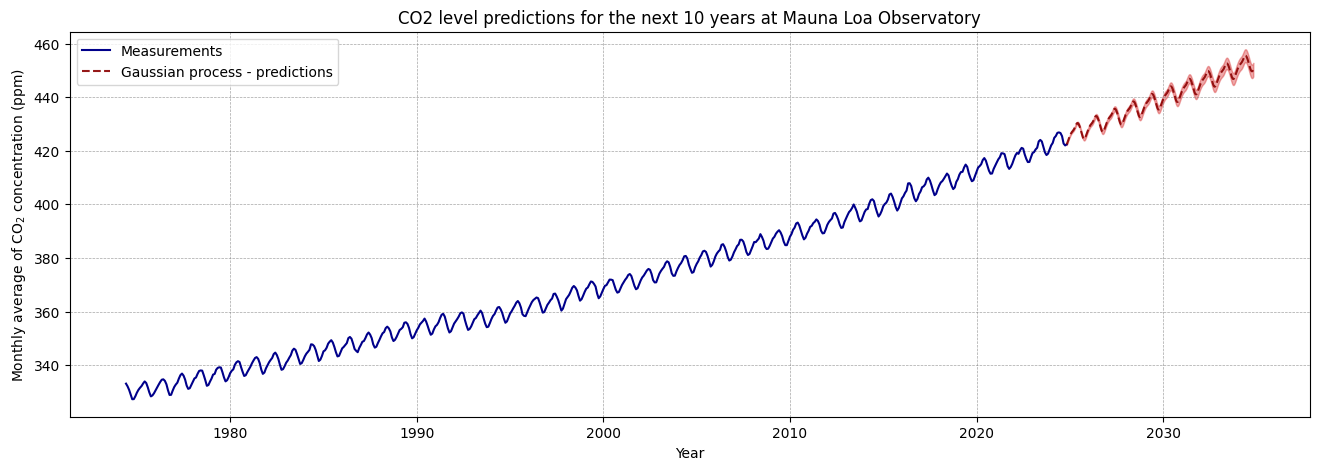

In [56]:
plt.figure(figsize=(16, 5))
plt.plot(X, y, color="darkblue", linestyle="-", label="Measurements")
plt.plot(X_test, mean_y_pred, linestyle="dashed",  color="darkred", alpha=0.9, label="Gaussian process - predictions")
plt.fill_between(
    X_test.ravel(),
    mean_y_pred - std_y_pred,
    mean_y_pred + std_y_pred,
    color="tab:red",
    alpha=0.4,
)
plt.grid(
    color="gray",      
    linestyle="--",   
    linewidth=0.5,   
    alpha=0.7         
)
plt.legend()
plt.xlabel("Year")
plt.ylabel("Monthly average of CO$_2$ concentration (ppm)")
_ = plt.title("CO2 level predictions for the next 10 years at Mauna Loa Observatory")

# 2. Short-Medium Model - predictions 1 month ahead
# SarimaX

In [57]:
# Load and prepare the dataset (replace 'df_combined_inner' with your DataFrame)
data = df_combined_inner.copy()

if not isinstance(data.index, pd.DatetimeIndex):
    raise ValueError("Data must have a datetime index")

co2_series = data['average_CO2'] # for such a short timeframe we don't really need all the features


In [58]:
# Step 1: Preprocess the data
co2_cleaned = co2_series.interpolate()
co2_diff = co2_cleaned.diff().dropna() # Differencing to remove trends

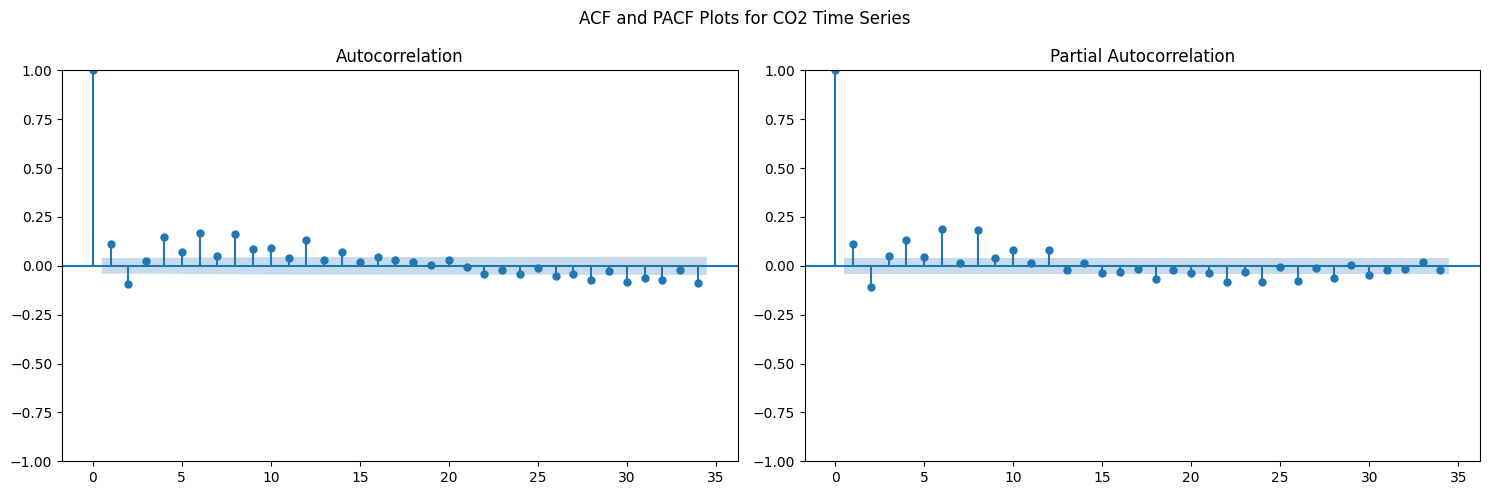

In [59]:
# Step 2: ACF and PACF for diagnostics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(co2_diff, ax=ax1)
plot_pacf(co2_diff, ax=ax2)
plt.suptitle('ACF and PACF Plots for CO2 Time Series')
plt.tight_layout()
plt.show()


In [60]:
# Step 3: finding best SARIMA order using grid search
pdq = [(0, 1, 1), (1, 1, 1), (1, 1, 2)]
seasonal_pdq = [(0, 1, 1, 12), (1, 1, 1, 12), (1, 1, 2, 12)]

best_aic = np.inf
best_order = None
best_seasonal_order = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(co2_diff, order=param, seasonal_order=seasonal_param)
            results = model.fit()

            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = seasonal_param
        except:
            continue

print(f"Best SARIMA Order: {best_order + best_seasonal_order}")


Best SARIMA Order: (1, 1, 2, 1, 1, 2, 12)


In [61]:
# Step 4: Train the SARIMA model
model = SARIMAX(co2_series, 
                order=best_order, 
                seasonal_order=best_seasonal_order)
model_fit = model.fit()

In [62]:
# Step 5: Forecast next month's CO2 levels
steps = 30
forecast = model_fit.get_forecast(steps=steps)
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

In [63]:
# Step 6: Visualize the extended forecast
# Historical range (last 5 months)
historical_range = co2_series.index[-5 * 30:]  # Approximately 5 months

In [64]:
# Forecast dates
forecast_dates = pd.date_range(start=co2_series.index[-1], periods=steps + 1)[1:]

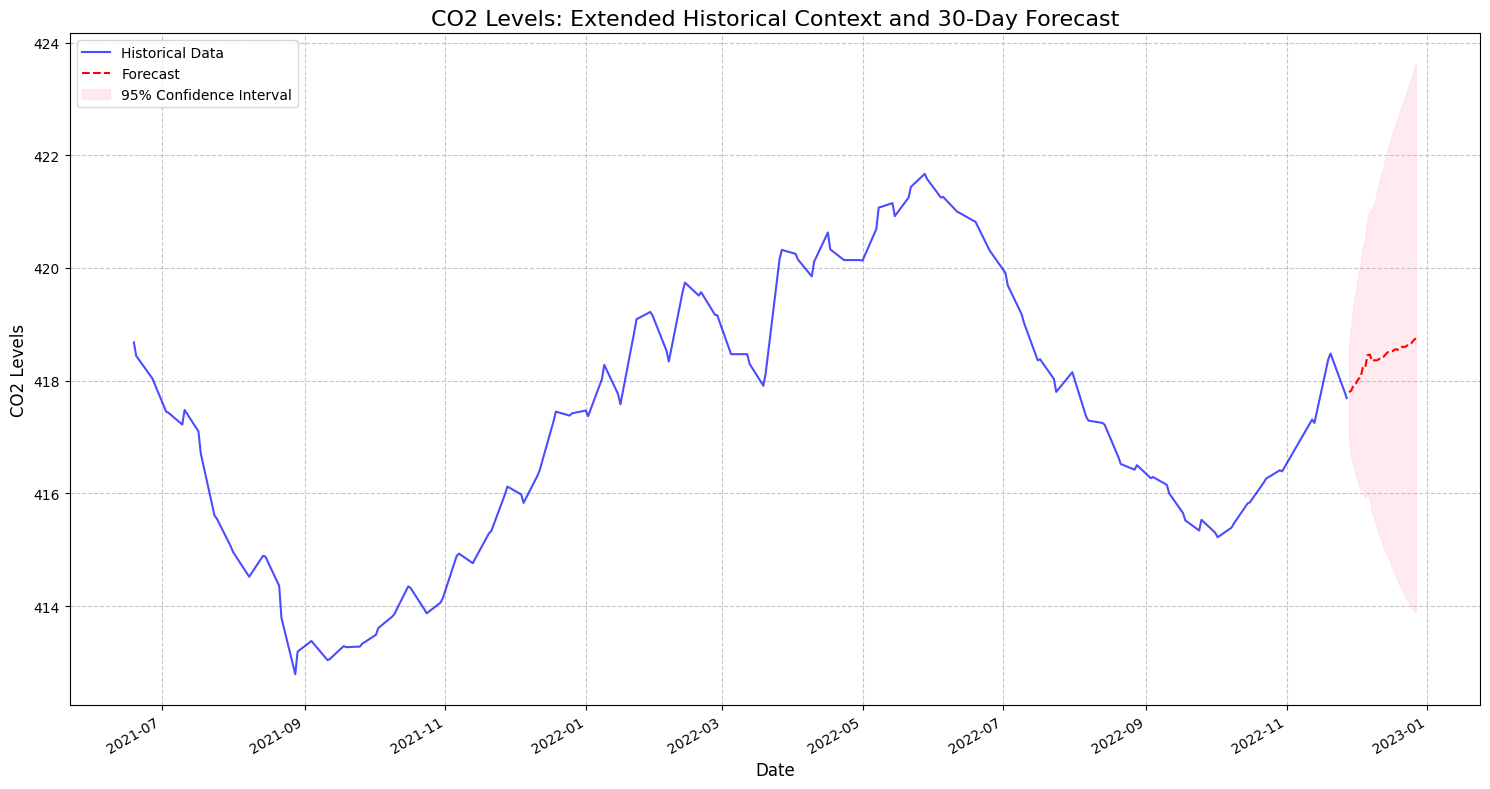

In [65]:
# plot
plt.figure(figsize=(15, 8))

# Plot extended historical data
plt.plot(historical_range, co2_series.loc[historical_range], 
         label='Historical Data', color='blue', alpha=0.7)

# Plot forecast
plt.plot(forecast_dates, predicted_mean, 
         label='Forecast', color='red', linestyle='--')

# confidence interval
plt.fill_between(forecast_dates, 
                 conf_int.iloc[:, 0], 
                 conf_int.iloc[:, 1], 
                 color='pink', alpha=0.3, 
                 label='95% Confidence Interval')

# Formatting
plt.title('CO2 Levels: Extended Historical Context and 30-Day Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('CO2 Levels', fontsize=12)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()


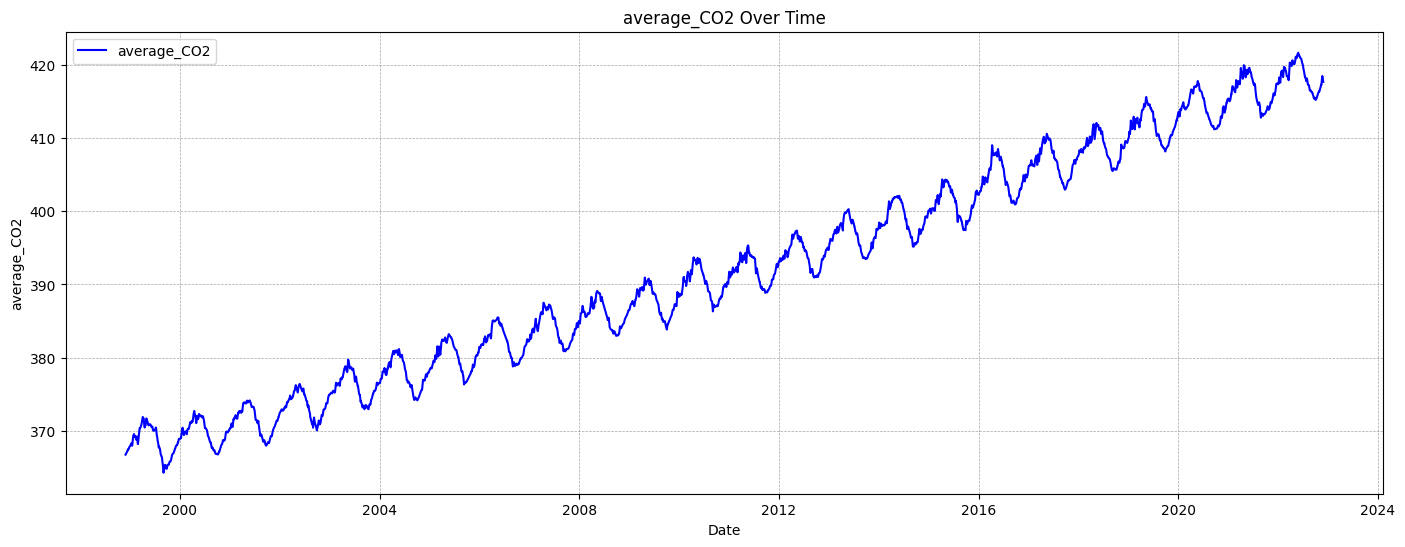

In [66]:
plot_column(df_combined_inner, 'average_CO2', 'blue')

# 3. Medium-Long term Model - predictions 5 years ahead
# Prophet

In [67]:
file_path = r'df_combined_inner.csv'
data = pd.read_csv(file_path, parse_dates=['datetime'])
prophet_df = data.rename(columns={'datetime': 'ds', 'average_CO2': 'y'})[['ds', 'y']]
prophet_df.dropna(inplace=True)

In [68]:
# Add other columns as regressors
other_columns = ['temperature', 'humidity', 'dew_point', 'precipitation', 'pressure',
                  'evapotranspiration', 'wind_speed', 'soil_temperature','value_CH4' ]  # Add your desired columns
for column in other_columns:
    prophet_df[column] = data[column]

In [69]:
# Initialize and Train Prophet Model
model = Prophet(
    changepoint_prior_scale=0.05,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    interval_width=0.95
)

In [70]:
# Add regressors
for column in other_columns:
    model.add_regressor(column)

model.fit(prophet_df)

16:17:19 - cmdstanpy - INFO - Chain [1] start processing
16:17:26 - cmdstanpy - INFO - Chain [1] done processing


In [71]:
# Generate Future Forecast (5 years = ~1825 days)
# Generate future dataframe
future = model.make_future_dataframe(periods=5*365)

In [72]:
# Extend regressors into the future
for column in other_columns:
    future[column] = data[column].iloc[-1]  # Use the last known value as a constant
forecast = model.predict(future)

<Figure size 1600x800 with 0 Axes>

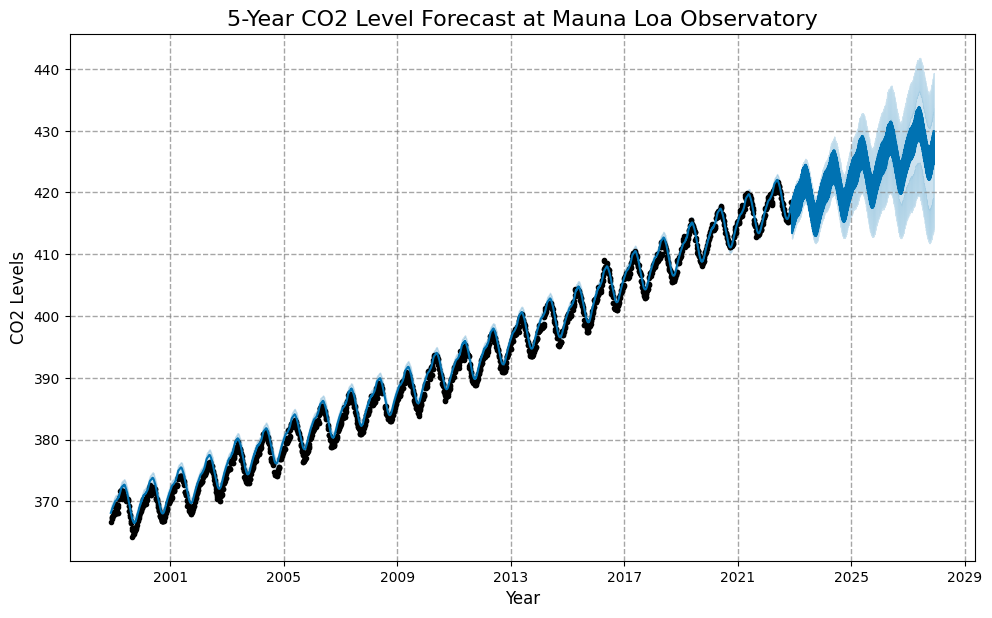

In [73]:
# Visualize the Forecast
plt.figure(figsize=(16, 8))
fig = model.plot(forecast)
plt.title('5-Year CO2 Level Forecast at Mauna Loa Observatory', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('CO2 Levels', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [74]:
# Analyze Forecast Summary
forecast_summary = {
    'Start of Forecast': forecast['ds'].min(),
    'End of Forecast': forecast['ds'].max(),
    'Initial Predicted Value': forecast['yhat'].iloc[0],
    'Final Predicted Value': forecast['yhat'].iloc[-1],
    'Projected Change': forecast['yhat'].iloc[-1] - forecast['yhat'].iloc[0],
    'Minimum Predicted Value': forecast['yhat_lower'].min(),
    'Maximum Predicted Value': forecast['yhat_upper'].max(),
}

print("Forecast Summary:")
for key, value in forecast_summary.items():
    print(f"{key}: {value}")


Forecast Summary:
Start of Forecast: 1998-11-29 00:00:00
End of Forecast: 2027-11-26 00:00:00
Initial Predicted Value: 368.1372764212973
Final Predicted Value: 429.9399532730512
Projected Change: 61.80267685175386
Minimum Predicted Value: 365.687351743666
Maximum Predicted Value: 441.77863522690245


# 4. Long term Model - predictions 20+ years ahead
# Gaussian Processes - all features

In [75]:
# Load dataset
df = pd.read_csv(r'df_combined_inner.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

In [76]:
# Resample and prepare data
df_monthly = df.resample('M').mean()
df_monthly.interpolate(method='time', inplace=True)
df_monthly.reset_index(inplace=True)

In [77]:
# Prepare features and target
X = (df_monthly['datetime'].dt.year + df_monthly['datetime'].dt.month / 12).to_numpy().reshape(-1, 1)
y = df_monthly['average_CO2'].to_numpy()

In [78]:
# Standardize target
y_mean = y.mean()
y_std = y.std()
y_normalized = (y - y_mean) / y_std

In [79]:
# Kernel selection
long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)
seasonal_kernel = (
    2.0**2 
    * RBF(length_scale=100.0) 
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)
irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)

co2_kernel = long_term_trend_kernel + seasonal_kernel + irregularities_kernel + noise_kernel

In [80]:
# Fit Gaussian Process
gp = GaussianProcessRegressor(kernel=co2_kernel, normalize_y=False)
gp.fit(X, y_normalized)

GaussianProcessRegressor(kernel=50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01))

In [81]:
# Prediction range
last_timestamp = df_monthly['datetime'].max()
last_year_fractional = last_timestamp.year + last_timestamp.month / 12
X_pred = np.linspace(last_year_fractional, last_year_fractional + 20, 240).reshape(-1, 1)

# Predictions
y_pred_normalized, std_pred = gp.predict(X_pred, return_std=True)
y_pred = y_pred_normalized * y_std + y_mean
std_pred *= y_std

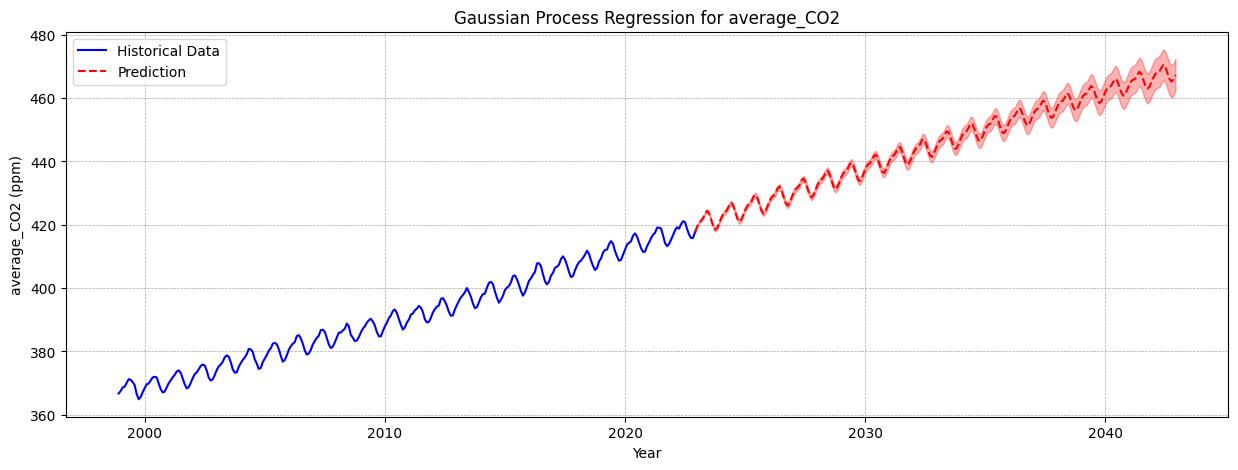

In [82]:
# Plotting
plt.figure(figsize=(15, 5))
plt.plot(X, y, label='Historical Data', color='blue')
plt.plot(X_pred, y_pred, label='Prediction', color='red', linestyle='--')
plt.fill_between(X_pred.ravel(), y_pred - std_pred, y_pred + std_pred, alpha=0.3, color='red')
plt.title('Gaussian Process Regression for average_CO2')
plt.xlabel('Year')
plt.ylabel('average_CO2 (ppm)')
plt.legend()
plt.grid(
    color="gray",      
    linestyle="--",   
    linewidth=0.5,   
    alpha=0.7)
plt.show()